In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle

import sagemaker
from sagemaker.xgboost import XGBoost
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

sns.set()

%matplotlib inline

# Exploratory Data Analysis

In [374]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# print missing data
print(train_data.isnull().sum())

def plot_bar_graph(train_data, feature):
    survived = train_data[train_data['Survived'] == 1][feature].value_counts()
    dead = train_data[train_data['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=False, figsize=(10, 5))
    
def plot_feature_count(train_data, feature):
    count = train_data[feature].value_counts()
    # mean = train_data[feature].mean()
    # print("mean = ", mean)
    print(count)
    df = pd.DataFrame([count])
    df.index = [feature]
    df.plot(kind='bar')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# Feature Engineering

n    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64
C    746
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


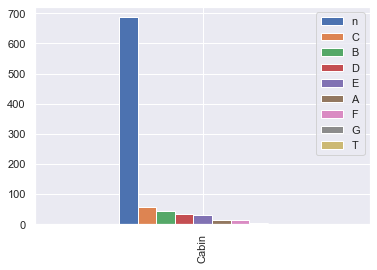

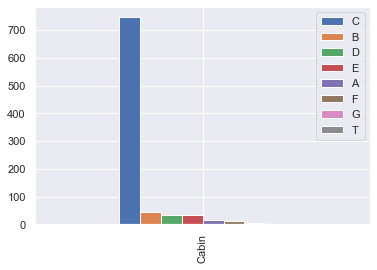

In [383]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# move target label to first column, requirement of sagemaker XGBoost
survived = train_data['Survived']
train_data.drop(labels=['Survived'], axis=1, inplace=True)

# remove irrelevant feature data
train_data.drop(labels=['Name', 'PassengerId', 'Ticket', 'Fare'], axis=1, inplace=True)

# insert target as first column
train_data.insert(0, 'Survived', survived)

# drop NaN rows for embarked
train_data = train_data.dropna(subset=['Embarked'])

# replace age NaN with mean age
mean_age = train_data['Age'].mean()
train_data['Age'] = train_data['Age'].fillna(mean_age)

# extract cabin number
train_data['Cabin'] = train_data['Cabin'].apply(lambda x : str(x)[0])

# round age
train_data['Age'] = train_data['Age'].apply(lambda x : int(x))

plot_feature_count(train_data, 'Cabin')

# replace cabin NaN with maximum 'S'
train_data['Cabin'] = train_data['Cabin'].apply(lambda x : 'C' if x == 'n' else x)

plot_feature_count(train_data, 'Cabin')

# label encode sex, cabin and embarked
label_encoder = LabelEncoder()
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])
train_data['Cabin'] = label_encoder.fit_transform(train_data['Cabin'])
train_data['Embarked'] = label_encoder.fit_transform(train_data['Embarked'])

bucket = 'sagemaker-us-east-1-756448110530'
prefix = 'dataset'

# plot_bar_graph('Cabin')

train_data.head(80)

train_xgboost, validation_xgboost, test_xgboost = np.split(train_data.sample(frac=1, random_state=1729), [int(0.7 * len(train_data)), int(0.9 * len(train_data))])

# remove header as it is not required by XGBoost
train_xgboost.to_csv('train_xgboost.csv', header=False, index=False)
validation_xgboost.to_csv('validation_xgboost.csv', header=False, index=False)
test_xgboost.to_csv('test_xgboost.csv', header=False, index=False)

In [384]:
sagemaker_session = sagemaker.Session()
train_path = sagemaker_session.upload_data(path='train_xgboost.csv', key_prefix='dataset')
validation_path = sagemaker_session.upload_data(path='validation_xgboost.csv', key_prefix='dataset')
test_path = sagemaker_session.upload_data(path='test.csv', key_prefix='test')
print(validation_path)

s3://sagemaker-us-east-1-756448110530/dataset/validation_xgboost.csv


In [385]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-1')

In [386]:
s3_input_train = sagemaker.s3_input(s3_data=train_path, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_path, content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data=test_path, content_type='csv')

# Train Model

In [387]:
estimator = sagemaker.estimator.Estimator(container,
                                          'AmazonSageMaker-ExecutionRole-20190815T111389',
                                          train_instance_count=1,
                                          train_instance_type='ml.m4.2xlarge',
                                          output_path='s3://{}/{}/output'.format(bucket, prefix),
                                          sagemaker_session=sagemaker_session,
                                          train_use_spot_instances=True,
                                          train_max_run=120,
                                          train_max_wait=180,
                                         )
estimator.set_hyperparameters(eta=0.1,
                             objective='binary:logistic',
                             num_round=25,
                             eval_metric='accuracy')

In [388]:
# estimator = XGBoost(entry_point='program.py',
#                     role='AmazonSageMaker-ExecutionRole-20190815T111389',
#                     train_instance_count=1,
#                     train_instance_type='local',
#                     framework_version='0.90-2',
#                     hyperparameters = {
#                         'max_depth':2,
#                         'eta':0.2,
#                         'objective':'binary:logistic',
#                         'silent':0,
#                         'num_round':100,
#                         'eval_metric':'auc'
#                     }
#                  )

In [389]:
estimator.fit({
    'train': s3_input_train,
    'validation': s3_input_validation
})

2020-04-01 19:26:48 Starting - Starting the training job...
2020-04-01 19:26:50 Starting - Launching requested ML instances...
2020-04-01 19:27:57 Starting - Preparing the instances for training......
2020-04-01 19:29:00 Downloading - Downloading input data...
2020-04-01 19:29:38 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value accuracy to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:29:41] 6